# Photometric standard curve for ABTS

In this notebook `calipytion` is used to create a calibration curve for [ABTS](https://pubchem.ncbi.nlm.nih.gov/compound/Abts), which was photometrically measured at 340 nm, ph 3.5, and 45°C.

✅ Models have been successfully fitted.


                                                  Model Overview                                                   
┏━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Name ┃ AIC  ┃ R squared ┃ RMSD   ┃ Equation                          ┃ Relative Parameter Standard Errors ┃
┡━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ linear     │ -205 │ 0.9991    │ 0.0346 │ a * ABTS + b                      │ b: 23.9%, a: 0.6%,                 │
│ quadratic  │ -199 │ 0.9989    │ 0.0366 │ a * ABTS**2 + b * ABTS + c        │ b: 2.2%, c: 29.8%, a: 158.1%,      │
│ qubic      │ -163 │ 0.9968    │ 0.0635 │ a * ABTS**3 + b * ABTS**2 + c *   │ b: 51.9%, c: 9.6%, a: 15.8%, d:    │
│            │      │           │        │ ABTS + d                          │ 72.7%,                             │
└────────────┴──────┴───────────┴────────┴───────────────────────────────────┴────────────────────────────────────┘

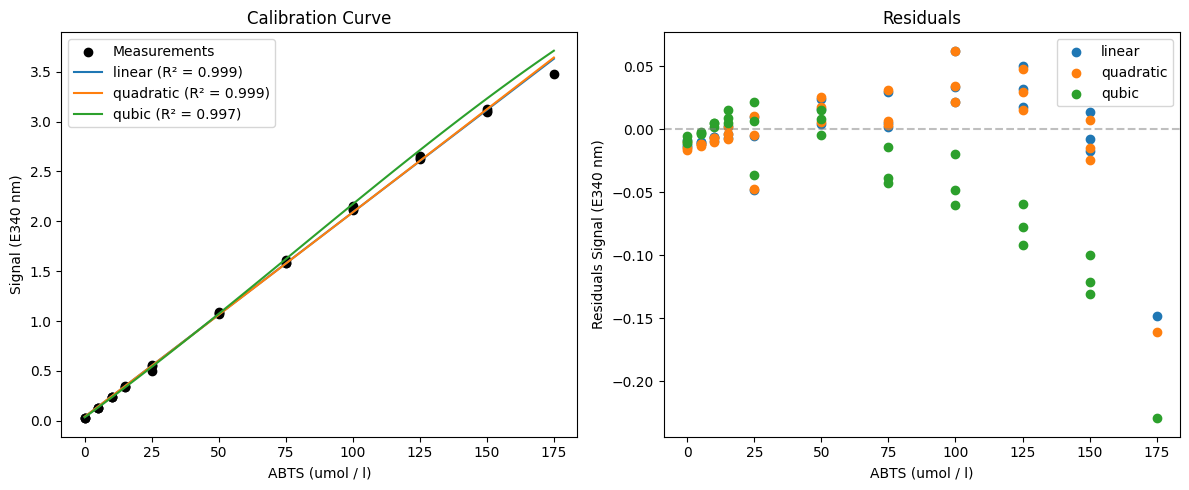

In [1]:
from calipytion import Calibrator

# Path to the CSV file containing the calibration data
path = "ABTS_calibration_pH3.5.csv"

# Create a calibrator from the CSV file
calibrator = Calibrator.from_csv(
    path=path,
    concentration_column_name="ABTS [uM]",
    molecule_id="ABTS",
    molecule_name="ABTS",
    pubchem_cid=5360881,
    cutoff=3.5,
    wavelength=340,
    conc_unit="umol / l",
)

# define the models to be fitted as potential signal laws
calibrator.models = []

linear = calibrator.add_model(
    name="linear",
    signal_law="a * ABTS + b",
)
quadratic = calibrator.add_model(
    name="quadratic",
    signal_law="a * ABTS**2 + b * ABTS + c",
)
cubic = calibrator.add_model(
    name="qubic",
    signal_law="a * ABTS**3 + b * ABTS**2 + c * ABTS + d",
)

# fit the models
calibrator.fit_models()

# create a standard from the linear model
standard = calibrator.create_standard(
    model=linear,
    ph=3.5,
    temperature=45,
    temp_unit="Celsius",
)

# visualize the standard
fig = calibrator.visualize_static(standard)

# save the standard to a JSON file
with open("abts_standard.json", "w") as f:
    f.write(standard.model_dump_json(indent=4))

Since the linear model has the lowest AIC and lowest relative standard deviations of the model parameters, it is the best model to describe the standard curve. Hence, the linear model is used for calibration.

In [2]:
import pyenzyme as pe
import math

doc = pe.read_enzymeml("../EnzymeML_Documents/SLAC_kinetic_assay_absorption.json")

# Apply the calibration to the document
calibrator.apply_to_enzymeml(doc)

# Remove measurements with NaN values
to_delete = []
for meas_id, meas in enumerate(doc.measurements):
    for species_id, species in enumerate(meas.species_data):
        if not species.data:
            continue

        # check if any of the values is float nan
        if any(math.isnan(value) for value in species.data):
            to_delete.append(meas_id)
            print(f"Measurement {meas_id} has NaN values --> Removed")

    # Remove the measurements
    for meas_id in sorted(to_delete, reverse=True):
        del doc.measurements[meas_id]

# Write the document to an EnzymeML file
pe.write_enzymeml(doc, "../EnzymeML_Documents/SLAC_kinetic_assay_concentration.json")

⚠️ Some concentrations could not be calculated and were replaced with nan values, since the provided signal is outside the calibration range [0.0, 175.0]. To calculate the concentration outside the calibration range, set 'extrapolate=True'.
⚠️ Some concentrations could not be calculated and were replaced with nan values, since the provided signal is outside the calibration range [0.0, 175.0]. To calculate the concentration outside the calibration range, set 'extrapolate=True'.
⚠️ Some concentrations could not be calculated and were replaced with nan values, since the provided signal is outside the calibration range [0.0, 175.0]. To calculate the concentration outside the calibration range, set 'extrapolate=True'.


✅ Applied calibration to 30 measurements
Measurement 0 has NaN values --> Removed
Measurement 1 has NaN values --> Removed


EnzymeML document written to ../EnzymeML_Documents/SLAC_kinetic_assay_concentration.json